In [1]:
%matplotlib inline
import numpy as np
from scipy import signal
from scipy.misc import imread, imsave, face
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt

In [2]:
def upsample(img, n):
    # размеры в n раз больше
    new_shape = tuple(map(lambda x: x * n, img.shape))
    
    new_img = np.empty(new_shape)
    for i in xrange(img.shape[0]):
        for j in xrange(img.shape[1]):
            new_img[i*n:(i+1)*n, j*n:(j+1)*n] = np.full((n, n), img[i, j])
    return new_img

In [3]:
def deconv2(c, b):
    Nout = c.shape[0] - b.shape[0] + 1
    Mout = c.shape[1] - b.shape[1] + 1
    b = np.pad(b, [(0, c.shape[0] - b.shape[0]), (0, c.shape[1] - b.shape[1])], "constant", constant_values=0)
    
    a = ifft2(fft2(c) / fft2(b))
    a = np.real(a[:Nout, :Mout])
    return a

In [4]:
def wiener_deconv2(c, b, snr):
    Nout = c.shape[0] - b.shape[0] + 1
    Mout = c.shape[1] - b.shape[1] + 1
    b = np.pad(b, [(0, Nout-1), (0, Mout-1)], "constant", constant_values=0)
    
    Fc = fft2(c)
    Fb = fft2(b)
    
    G = (Fb * np.conj(Fb)) / (Fb * np.conj(Fb) + 1.0 / snr) / Fb
    a = ifft2(G * Fc)
    a = np.real(a[:Nout, :Mout])
    a[abs(a) < 1e-12] = 0.0
    return a

In [5]:
def show_pics(pics, titles):
    _, axis = plt.subplots(nrows=1, ncols=len(pics), sharex=True, sharey=True, figsize=(14,6))
    for i in xrange(len(pics)):
        axis[i].imshow(pics[i], cmap='Greys_r')
#         axis[i].axis('off')
        axis[i].set_title(titles[i])
    plt.show()

In [221]:
def generate_sample_images(img, psf):
    k = psf.shape[0]; # assume psf as square template
    
    # pad image with zeros
    padded = np.pad(img, [(k-1, k-1), (k-1, k-1)], "constant", constant_values=0)
    
    sample_rows, sample_cols = padded.shape[0] / k, padded.shape[1] / k
    samples = np.empty((k, k, sample_rows, sample_cols))  
    
    # anchor_y, anchor_x - координаты в img, с которых мы начинаем прикладывать левый верхний край шаблона
    for anchor_y in xrange(k):
        for anchor_x in xrange(k):
            tmp = np.zeros((sample_rows, sample_cols))
            
            # y, x - coordinates where the template (upper left corner) is attached
            for y in xrange(anchor_y, padded.shape[0] - (k-1), k):
                for x in xrange(anchor_x, padded.shape[1] - (k-1), k):
                    i = (y - anchor_y) / k
                    j = (x - anchor_x) / k
                    tmp[i, j] = np.sum(padded[y:y+k, x:x+k] * psf)
            samples[anchor_y, anchor_x] = tmp
    return samples

In [222]:
def conv_from_samples(samples, to_shape=None):
    k, _, sample_rows, sample_cols = samples.shape # assume psf as square template
    if to_shape:
        sampled = np.empty(to_shape)
    else:
        sampled = np.empty((k*sample_rows, k*sample_cols))
                           
    for anchor_y in xrange(k):
        for anchor_x in xrange(k): 
            for y in xrange(anchor_y, sampled.shape[0], k):
                for x in xrange(anchor_x, sampled.shape[1], k):
                    i = (y - anchor_y) / k
                    j = (x - anchor_x) / k
                    sampled[y, x] = samples[anchor_y, anchor_x, i, j]
    return sampled

In [223]:
src = face(gray=True)

In [182]:
src.shape

(768, 1024)

In [224]:
k = 23 # psfSize
psf = np.ones((k, k)) / k ** 2

In [225]:
samples = generate_sample_images(src, psf)

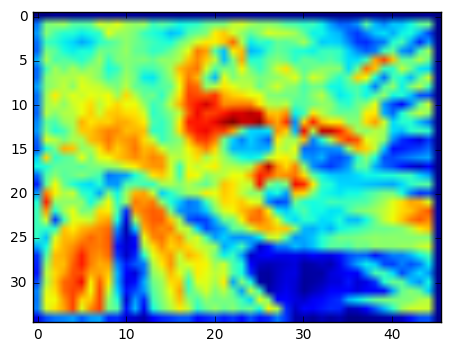

In [203]:
plt.imshow(samples[0, 10])

In [226]:
conv1 = signal.convolve2d(src, psf)

In [227]:
sampled = conv_from_samples(samples, conv1.shape)

(768, 1024) (790, 1046) (790, 1046)
1.13686837722e-12
1.4655469922e-15


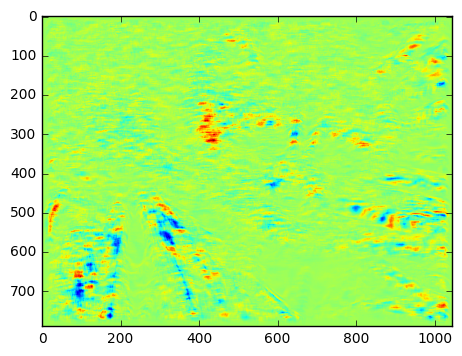

In [228]:
print src.shape, conv1.shape, sampled.shape
print (conv1[k-1:-(k-1), k-1:-(k-1)] - sampled[k-1:-(k-1), k-1:-(k-1)]).max()
plt.imshow((conv1 - sampled) / np.max(conv1 - sampled))
print (conv1 - sampled).mean()

In [190]:
d = conv1 - sampled
print conv1[0, 1045], sampled[0, 1045]

0.258979206049 0.0


In [179]:
samples[0, 10, 0, 45], samples.shape

(0.0, (23, 23, 35, 46))

In [162]:
1045 % 23, 1045 / 23

(10, 45)

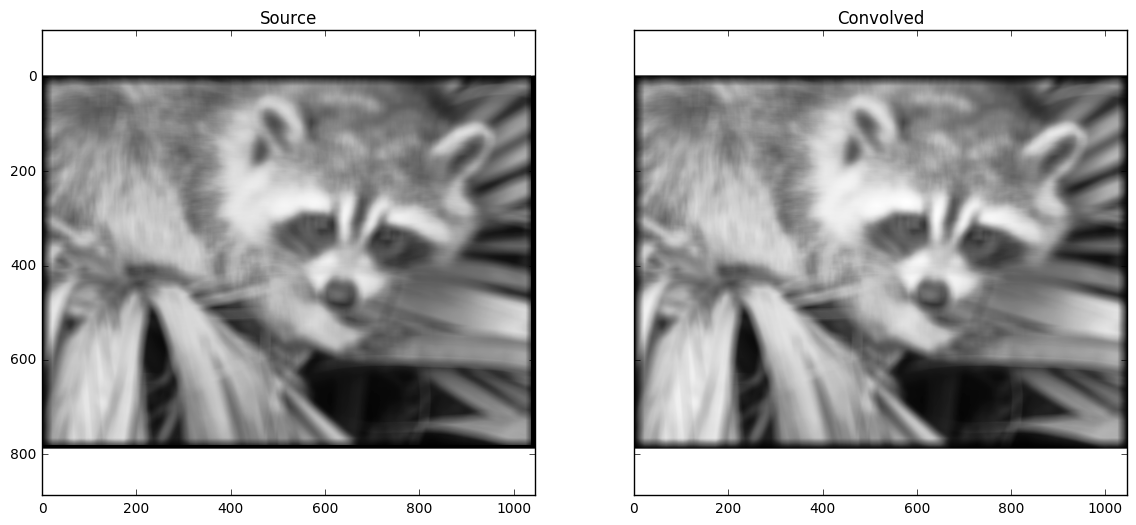

In [112]:
show_pics(pics=[sampled, conv1], titles=["Source", "Convolved"])

Разворачиваем и сравниваем с исходным изображением

In [ ]:
rest1 = deconv2(conv1, psf)
show_pics(pics=[src, rest1], titles=["Source", "Restored"])

Сгенерим картинки, будто бы от наших механических сдвигов. Мы хотим получить то же, что и в результате свертки.

In [ ]:
sampled.shape, conv1.shape

In [116]:
print (sampled - conv1[2*bh:-2*bh,2*bw:-2*bw]).mean()

NameError: name 'bh' is not defined

In [ ]:
show_pics(pics=[conv1[2*bh:-2*bh,2*bw:-2*bw], sampled], titles=["Convolved", "Sampled"])

In [114]:
conv1[0,1045], sampled[0,1045]

(0.25897920604914937, 7.8925346840289219)

Два способа получить размазанные изображения идентичны

Развернем и сравним с исходной

In [ ]:
deconved = deconv2(sampled, psf)

In [ ]:
show_pics([src[2*bh:-2*bh,2*bw:-2*bw], deconved], ["Source", "Deconvolved"])

Нужен какой-то критерий эффективности восстановления картинки.
Последовательность действий у нас такая: 
картинка -> свернутая картинка -> свернутая картинка с шумом -> развернутая картинка

In [ ]:
def criteria(orig, reconstr):
    d = orig - reconstr
    print "mean: ", d.mean(), ", std: ", d.std()

In [ ]:
a = face(gray=True)

In [ ]:
psf_sz = 10
b = np.ones((psf_sz, psf_sz)) / (psf_sz ** 2)

c = signal.convolve2d(a, b)
sigma = 5
n = np.random.normal(0, sigma, c.shape)
Fa = fft2(np.pad(a, [(0, c.shape[0]-a.shape[0]), (0, c.shape[1]-a.shape[1])], "constant", constant_values=0))
Fn = fft2(n)
snr = (Fa * Fa.conj()) / (Fn * Fn.conj())
d = wiener_deconv2(c + n, b, snr)
Fd = fft2(d)
Fa = fft2(a)
a_mag = np.log(np.abs(Fa))
# a_mag /= a_mag.mean()
d_mag = np.log(np.abs(Fd))

Fs = fft2(sample_imgs[0,0])
s_mag = np.log(np.abs(Fs))

# d_mag /= d_mag.mean()
# print a_mag[100:110, 100:110]
# print a_mag.mean(), d_mag.mean()
show_pics([upsample(s_mag, 23), d_mag], ["Original spectre", "Restored spectre"])
# criteria(a, d)
# show_pics([a, d], ['a', 'd'])

In [ ]:
plt.imshow(s_mag, cmap='Greys_r')

In [ ]:
plt.imshow(d_mag, cmap='Greys_r')

In [ ]:
sigma = 1e-3
s_noisy = sampled + np.random.normal(0, sigma, sampled.shape)
reconstr = wiener_deconv2(s_noisy, psf, 1e6)
criteria(src[2*bh:-2*bh,2*bw:-2*bw], reconstr)
show_pics([src[2*bh:-2*bh,2*bw:-2*bw], reconstr], ["Source", "Reconstructed"])

In [ ]:
print src.shape, reconstr.shape

In [ ]:
print criteria(src[2*bh:-2*bh,2*bw:-2*bw], reconstr)

In [ ]:
# from ipywidgets.widgets import *

# def wiener_deconv_snr_research(noise_sigma, snr):
#     print "call", noise_sigma, snr
#     noisy = sampled + np.random.normal(0, noise_sigma, sampled.shape)
#     reconstr = wiener_deconv2(noisy, psf, snr)
#     show_pics([src[2*bh:-2*bh,2*bw:-2*bw], reconstr, noisy], ["Source", "Reconstructed", "Sampled Noisy"])

In [ ]:
# def show_noise_impact(noise_sigma):
#     noisy = sampled + np.random.normal(0, noise_sigma, sampled.shape)
#     show_pics([sampled, noisy], ["Sampled", "Noisy"])

In [ ]:
# interact(wiener_deconv_snr_research, noise_sigma=(1, 10, 1), snr=(1, 100, 0.5))

In [ ]:
def wiener_deconv2_sigma(b, p, sigma):
    Nout = b.shape[0] - p.shape[0] + 1
    Mout = b.shape[1] - p.shape[1] + 1
    p = np.pad(p, [(0, Nout-1), (0, Mout-1)], "constant", constant_values=0)
    
    Fb = fft2(b)
    Fp = fft2(p)
    
    snr = (Fb * Fb.conj() + sigma**2) / (Fp * Fp.conj() * sigma**2)
    G = (Fp * Fp.conj()) / (Fp * Fp.conj() + 1.0 / snr) / Fp
    a = ifft2(G * Fb)
    a = np.real(a[:Nout, :Mout])
    a[abs(a) < 1e-12] = 0.0
    return a

In [ ]:
a = np.array([[1, 2, 0, 3, 7], 
              [0, 10, 1, 1, 1], 
              [32, 12, 0, 0, 0],
              [2, 1, 3, 5, 0],
              [3, 0, 4, 2, 1]])

b = np.array([[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]]) / 9.0
# psf_sz = 3
# b = np.ones((psf_sz, psf_sz)) / (psf_sz**2)

c = signal.convolve2d(a, b)

sigma = 0.02
print c.std()
n = np.random.normal(0, sigma, c.shape)
d = wiener_deconv2(c + n, b, 2.5)
print (d - a).std()
# print d

In [ ]:
a = face(gray=True)
psf_sz = 23
b = np.ones((psf_sz, psf_sz)) / (psf_sz**2)
c = signal.convolve2d(a, b)
sigma = 0.2
n = np.random.normal(0, sigma, c.shape)
d = wiener_deconv2_sigma(c + n, b, sigma)
print (d - a).std()
show_pics(pics=[a, d], titles=["A", "D"])